In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

LANGFUSE_SECRET_KEY = os.getenv("LANGFUSE_SECRET_KEY")
LANGFUSE_PUBLIC_KEY= os.getenv("LANGFUSE_PUBLIC_KEY")



In [2]:
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"
os.environ["HAYSTACK_CONTENT_TRACING_ENABLED"] = "True"
os.environ["TOKENIZERS_PARALLELISM"] = "True"


In [3]:
from haystack import Pipeline

from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack_integrations.components.connectors.langfuse import LangfuseConnector
from haystack.utils import Secret

from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.components.writers import DocumentWriter

document_store = InMemoryDocumentStore()


converter = TextFileToDocument()
splitter = DocumentSplitter(split_by='sentence', split_length=1)
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

indexing_pipeline.connect("converter.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

indexing_pipeline.run({"converter": {"sources": ["../data/tolkien.txt",
                                                 "../data/George_RR_Martin.txt"]}})

No abbreviations file found for en. Using default abbreviations.
Batches: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


{'writer': {'documents_written': 92}}

In [4]:
rag_prompt_template = """
Answer the following query given the documents.
If the answer is not contained within the documents, reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""
tracer = LangfuseConnector("Basic RAG Pipeline")
query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever =InMemoryEmbeddingRetriever(document_store=document_store, top_k = 3)
prompt = PromptBuilder(template=rag_prompt_template)
generator = OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))

rag = Pipeline()

rag.add_component("tracer", tracer)
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever",retriever )
rag.add_component("prompt_builder", prompt)
rag.add_component("llm", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "llm")


🚅 Components
  - tracer: LangfuseConnector
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

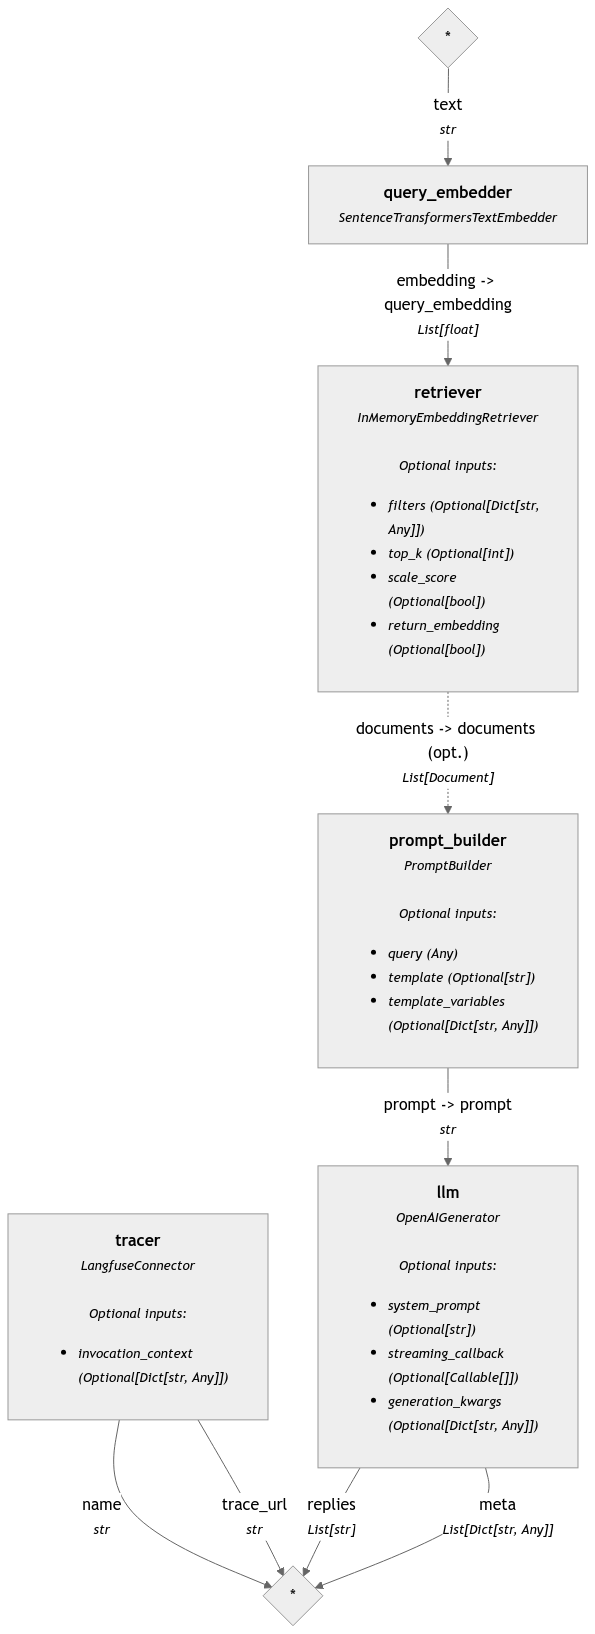

In [5]:
rag.show()

In [6]:
document_store.count_documents()

92

In [7]:
query = "Who is J. R.R. Tolkien?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query}},
        include_outputs_from={"tracer"}
)


rich.print(result["llm"]["replies"][0])

Batches: 100%|██████████| 1/1 [00:00<00:00, 26.43it/s]


John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the
most influential and celebrated figures in literary history, particularly within the realm of high fantasy.

In [8]:
result

{'tracer': {'name': 'Basic RAG Pipeline',
  'trace_url': 'https://cloud.langfuse.com/project/cm3shyi46001aq477mz32lb4z/traces/487dab1e-5423-41f5-b53c-6aee878902e7'},
 'llm': {'replies': ['John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the most influential and celebrated figures in literary history, particularly within the realm of high fantasy.'],
  'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 50,
     'prompt_tokens': 142,
     'total_tokens': 192,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]}}